## Project 2: Deep Learning
### By Mira Rayson
### GDAA 2010
### 04/12/2024

In [178]:
# Importing necessary modules for project

import os
import torchvision
import torch
import sklearn
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import numpy as np

from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


Checking to see if GPU support is available (ended up being unavailable and unfortunately had to continue the project using just my CPU).

In [163]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("GPU support is available.")
else:
    print("GPU support is not available. Using CPU.")

GPU support is not available. Using CPU.


### Steps 1-5: 
Loading in PyTorch's MNIST dataset, converting image to PyTorch tensors, resizing said tensors, setting the batch size, then creating Test/Train subsets. 

I chose a batch size of 8 to ensure regularization and generalization, as a smaller batch size exposes the model to a variety of examples within each epoch which can represent the data in a more robust way. Looking back, however, I probably should have chosen a larger batch size as my processing/training time was a bit painstakingly long. This may have also been because of the fact I was unable to use any GPU support, though.

In [164]:
# Defining directory
download_path = r'C:\\Users\\mirar\\OneDrive\\Desktop\\WINTER_TERM\\Mining_Modeling\\P2\\MNIST'

# Checking if the directory exists. If not, creating it
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Defining transformation
transform = transforms.ToTensor()

# Setting batch size
batch_size = 8

# Creating Training dataset object
trainset = torchvision.datasets.MNIST(root=download_path, train=True, download=True, transform=transform)

# Creating Testing dataset object
testset = torchvision.datasets.MNIST(root=download_path, train=False, download=True, transform=transform)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [165]:
# Verifying the shape of an individual tensor
train_iter = iter(trainset)

image, label = next(train_iter)

image.shape, label

(torch.Size([1, 28, 28]), 5)

### Step 6:
Plotting example image to ensure data has been loaded correctly.

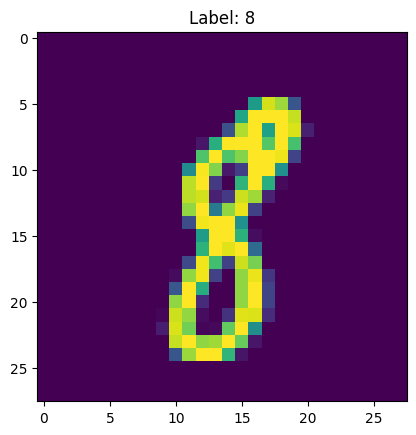

In [166]:
# Selecting image from the Training data by it's index number
index = 300  

# Retrieving the image and it's label
image, label = trainset[index] 

plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {classes[label]}")
plt.show()

### Step 7:
Determining length of Training and Testing subsets, then subsetting the Training data into Training and Validation datasets using a proportional split of 80% for Training, and 20% for Validation.

In [167]:
# Confirming size of the Train/Test subsets
len(trainset), len(testset)

(60000, 10000)

In [168]:
# Using PyTorch to create further subsets of the Training subset
trainset, valset = torch.utils.data.random_split(trainset, [0.80, 0.20])
len(trainset), len(valset), len(testset)

(48000, 12000, 10000)

In [169]:
# Visualizing the number of batches in the new Training and Validation subsets
print(f'Number of batches in the training set: {int(48000 / batch_size)}')
print(f'Number of batches in the validation set: {int(12000 / batch_size)}')

Number of batches in the training set: 6000
Number of batches in the validation set: 1500


### Step 9:
Defining CNN architecture, ensuring formatting for greyscale (MNIST) imagery.

In [170]:
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2) # Changed first instance of in_channels to 1 for MNIST greyscale imagery
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)

        
        # Calculating size of the flattened features after all convolutional and pooling layers
        self._flattened_features = self._get_conv_output_size()

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=self._flattened_features, out_features=1024)
        self.drop1 = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.drop2 = nn.Dropout(p=0.3)
        self.out = nn.Linear(in_features=512, out_features=10)  # Changed out_features to 10 for MNIST

    def _get_conv_output_size(self):
        # Creating a dummy input to pass through the convolutional layers only
        dummy_input = torch.zeros(1, 1, 28, 28)  # Using MNIST dimensions
        dummy_input = self.conv1(dummy_input)
        dummy_input = self.pool1(dummy_input)
        dummy_input = self.conv2(dummy_input)
        dummy_input = self.pool2(dummy_input)
        dummy_input = self.conv3(dummy_input)
        dummy_input = self.pool3(dummy_input)
        print("Shape before flattening:", dummy_input.shape) 
        flattened_size = int(dummy_input.view(dummy_input.size(0), -1).size(1))
        print("Flattened size:", flattened_size)
        return int(dummy_input.view(dummy_input.size(0), -1).size(1))


    def forward(self, x):
        # Convolutional and pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flattening the output for the fully connected layers
        x = x.view(-1, self._flattened_features)

        # Fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        # Output layer
        x = self.out(x)

        return x

### Step 11:
Selecting loss function and optimization technique.

I chose to not deviate from the function/technique used in class as I believe these suited the MNIST dataset well. 'nn.CrossEntropyLoss()' is great for when dealing with classification wherein each sample only belongs to one class, and 'optim.Adam' is known to be a good default optimizer and therefore a good choice for a standard built-in dataset such as MNIST.

In [171]:
# Instantiating the model
net = NeuralNet()

# Choosing loss function
criterion = nn.CrossEntropyLoss()

# Choosing optimization technique
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Shape before flattening: torch.Size([1, 256, 3, 3])
Flattened size: 2304


### Step 12:
Creating Training and Validation epochs, defining the training loop.

In [172]:
def train_one_epoch():
  net.train(True)

  running_loss = 0.0
  running_accuracy = 0.0

  for batch_index, (inputs, labels) in enumerate(trainset):

    optimizer.zero_grad()

    outputs = net(inputs) 
    correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
    running_accuracy += correct / batch_size

    loss = criterion(outputs, torch.tensor(labels).unsqueeze(0).repeat(outputs.size(0))) # Heavily modified from template
    running_loss += loss.item()
    loss.backward()
    optimizer.step()

    if batch_index % 500 == 499:  # print every 500 batches as this dataset is quite large
      avg_loss_across_batches = running_loss / 500
      avg_acc_across_batches = (running_accuracy / 500) * 100
      print('Batch {0}, Loss: {1:.3f}, Accuracy: {2:.1f}%'.format(batch_index+1,
                                                          avg_loss_across_batches,
                                                          avg_acc_across_batches))
      running_loss = 0.0
      running_accuracy = 0.0


In [173]:
def validate_one_epoch():
    net.train(False)
    running_loss = 0.0
    running_accuracy = 0.0
    
    for i, (inputs, labels) in enumerate(valset):
        
        with torch.no_grad():
            outputs = net(inputs) 
            correct = torch.sum(labels == torch.argmax(outputs, dim=1)).item()
            running_accuracy += correct / batch_size
            loss = criterion(outputs, torch.tensor(labels).unsqueeze(0).repeat(outputs.size(0))) # Heavily modified from template
            running_loss += loss.item()
        
    avg_loss_across_batches = running_loss / len(valset)
    avg_acc_across_batches = (running_accuracy / len(valset)) * 100
    
    print('Val Loss: {0:.3f}, Val Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                            avg_acc_across_batches))
    print('***************************************************')
    print()

An important note here is the modification of the Loss function in the Training and Validation epochs, deviating from the template given in 'dl_leafsnap.ipynb'. 

The template: 'loss = criterion(outputs, labels)'

My code: 'loss = criterion(outputs, torch.tensor(labels).unsqueeze(0).repeat(outputs.size(0)))'

I was running into extensive trouble with the size of the input tensor to the fully connected layers not matching the expected size - "RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x9 and 2304x1024)." So I decieded to try ensuring within the Loss function that the 'labels' tensor had the same shape as the 'outputs' tensor. I essentially just ensured that all outputs were the same shape by reaffiriming/repeating tensor conversion and the 'unsqueeze' function.

The error I was facting likely stemmed from the fact the labels in the MNIST dataset may have not been provided in the expected format, or perhaps an issue occured in the data loading and preprocessing that I did not catch. However, if I am being honest I am still unsure of why exactly this error persisted as long as it did in my workflow.






### Step 12 cont.:

After running with just 1 epoch (took 20 minutes using CPU), the model had a loss of 0.054 and an accuracy score of 12.3%. Certainly not good by any means, however at this point I was just giddy the model ran successfully! So I did not touch anything else and moved on to running with multiple epochs.


Running with 5 epochs took an unfortunate amount of time (~90 minutes, which was expected) however yielded marginally better results, with a loss of 0.086 and accuracy of 12.4%.

The Loss scores were quite good, however the Accuracy scores were not. This is telling me that the there is some overfitting going on with the Training data, or perhaps some complexity or imbalance within said data.

In [177]:
num_epochs = 5

for epoch_index in range(num_epochs):
    print(f'Epoch: {epoch_index + 1}\n')
    
    train_one_epoch()
    validate_one_epoch()
    
print('Finished Training')

Epoch: 1

Batch 500, Loss: 0.010, Accuracy: 12.4%
Batch 1000, Loss: 0.009, Accuracy: 12.4%
Batch 1500, Loss: 0.018, Accuracy: 12.4%
Batch 2000, Loss: 0.004, Accuracy: 12.5%
Batch 2500, Loss: 0.045, Accuracy: 12.4%
Batch 3000, Loss: 0.074, Accuracy: 12.2%
Batch 3500, Loss: 0.073, Accuracy: 12.2%
Batch 4000, Loss: 0.035, Accuracy: 12.3%
Batch 4500, Loss: 0.032, Accuracy: 12.3%
Batch 5000, Loss: 0.063, Accuracy: 12.3%
Batch 5500, Loss: 0.017, Accuracy: 12.4%
Batch 6000, Loss: 0.113, Accuracy: 12.2%
Batch 6500, Loss: 0.040, Accuracy: 12.4%
Batch 7000, Loss: 0.083, Accuracy: 12.3%
Batch 7500, Loss: 0.083, Accuracy: 12.1%
Batch 8000, Loss: 0.055, Accuracy: 12.3%
Batch 8500, Loss: 0.050, Accuracy: 12.3%
Batch 9000, Loss: 0.026, Accuracy: 12.3%
Batch 9500, Loss: 0.052, Accuracy: 12.3%
Batch 10000, Loss: 0.019, Accuracy: 12.4%
Batch 10500, Loss: 0.075, Accuracy: 12.3%
Batch 11000, Loss: 0.034, Accuracy: 12.3%
Batch 11500, Loss: 0.046, Accuracy: 12.4%
Batch 12000, Loss: 0.068, Accuracy: 12.3%
Ba

### Step 13:
Evaluating the model

In [180]:
# Define DataLoader for test set
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Set the model to evaluation mode
net.eval()

# Get predicted labels from the model
predicted_labels = []
true_labels = []

# Iterate through the test dataset using DataLoader
for images, labels in testloader:
    # Forward pass
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    
    # Collect predicted and true labels
    predicted_labels.extend(predicted.tolist())
    true_labels.extend(labels.tolist())

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=classes)
print("Classification Report:\n", class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.9891
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.97      1.00      0.99       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Confusion Matrix:
 [[ 976    0    1    1    0    0    1    0    1    0]
 [   1 1119    1    4    0    0    6    1    3    0]
 [   0    0 1027    0    0    0    0    3    2    0]
 [   0    0    0 1007 

The model performed very well, with an accuracy of 98.9%.

I am still a little confused as to why the accuracy jumped up so high here, when the training yielded such low scores. I did not perform much hyperparameter tuning nor model modification between these steps. Perhaps the Training and Validation runs were limited due to the number of epochs, or the subsets were too limited and/or random or complex.

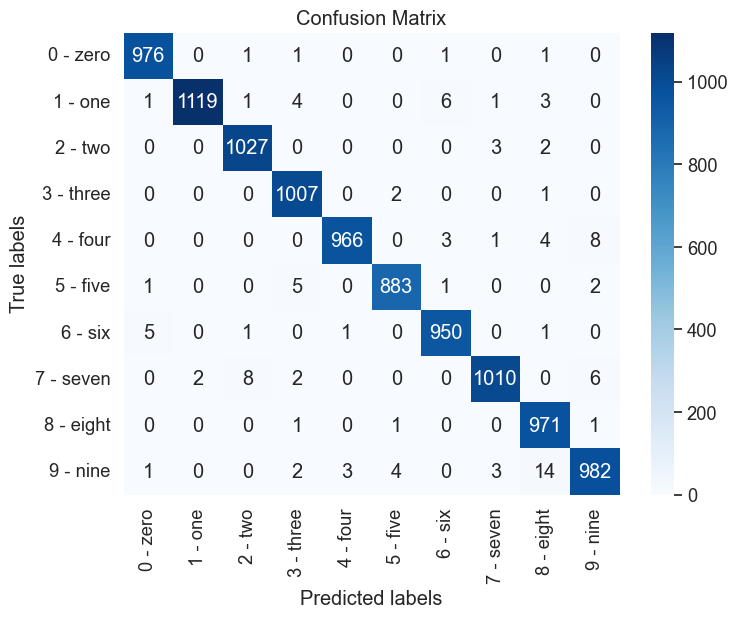

In [183]:
# Creating a Confusion Matrix with greater readability

# Extract class labels from the dataset
class_labels = testset.classes

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Set font scale
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

One can see here that overall, the model does a great job at accurately classifying the imagery. Classes Four and Nine are those with the highest instances of misclassification. Four is most commonly mistaken as Nine, and Nine most commonly mistaken as Eight. This could lend its hand to some inherent similarities between these classes, an imbalance in the training data (underrepresentation of certain classes), and/or model complexity.


### Step 14: 
Saving the model so I can then pass my test data through.

In [184]:
# Defining the path to save the model
save_dir = r"C:\\Users\\mirar\\OneDrive\\Desktop\\WINTER_TERM\\Mining_Modeling\\P2\\Model"

# Defining the file name for the saved model
model_name = "mnist_epoch1.pth"
save_path = os.path.join(save_dir, model_name)

# Saving the model
torch.save(net.state_dict(), save_path)

print(f"Model saved at: {save_path}")

Model saved at: C:\\Users\\mirar\\OneDrive\\Desktop\\WINTER_TERM\\Mining_Modeling\\P2\\Model\mnist_epoch1.pth


### Step 15: 
Loading the saved model back into the project to test it with the Test data subset created earlier on.

In [194]:
# Define the model architecture
net_test = NeuralNet()

save_path = os.path.join(save_dir, model_name)
# Load the saved model state dictionary
net_test.load_state_dict(torch.load(save_path))

# Evaluate the model on the test data
net_test.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testset:
        outputs = net_test(images.unsqueeze(0))
        _, predicted = torch.max(outputs, 1)
        total += 1  # Increment total by 1 for each image
        correct += (predicted == labels).item()  # Compare predicted labels directly with the ground truth labels
# Calculate accuracy
accuracy = 100 * correct / total
print(f"Accuracy of the network on the test images: {accuracy:.2f}%")

Shape before flattening: torch.Size([1, 256, 3, 3])
Flattened size: 2304
Accuracy of the network on the test images: 98.91%
